### Курсовой проект "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"
### Студент Абрамов А.В.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
# Формируем датафреймы
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Замечаем, что признак Healthcare_1 в более половины строк имеет значение NaN => его можно дропнуть.
Что касается признака LifeSquare, имеющего значение NaN в около четверти строк, то проверим его корреляцию с близкими признаками. В случае высокой взаимной корреляции с каким-либо из них, признак LifeSquare можно дропнуть.

In [4]:
train.drop(['Healthcare_1'], axis=1, inplace=True)

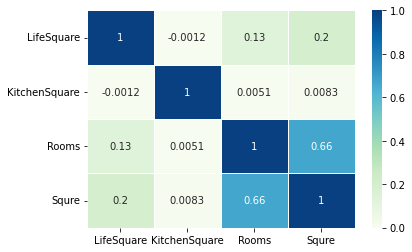

In [5]:
# Построим тепловую карту таблицы корелляции признаков LifeSquare, KitchenSquare, Rooms, Squre
square_check = pd.DataFrame({'LifeSquare': train['LifeSquare'], 
                             'KitchenSquare': train['KitchenSquare'],
                             'Rooms': train['Rooms'],
                             'Squre': train['Square']})
sns.heatmap(square_check.corr(), annot=True, linewidths=0.5, cmap='GnBu')
plt.show()

Видно, что признак LifeSquare слабо коррелирует с остальными. Поэтому заменим все его значения NaN на медианное значение

In [6]:
train.fillna(train['LifeSquare'].median(), inplace=True)

In [7]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

In [8]:
# Проанализируем, какие значения встречаются по каждому признаку
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399
std,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


In [9]:
# Просмотрим какие значения и как часто встречаются в столбце Rooms
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [10]:
# Заменим аномальные значения кол-ва комнат на медианное значение
train.loc[train['Rooms'].isin([0, 10, 19]), 'Rooms'] = train['Rooms'].median() 

In [11]:
# Видно, что 2 наибольших значения поля HouseYear - это выбросы (похоже, ошибки ввода), а наибольший год постройки - 2020 
train['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [12]:
# Удаляем строки со значениями поля HouseYear больше 2020
train = train[train['HouseYear'] <= 2020]

In [13]:
train['HouseYear'].sort_values(ascending=False)

1499    2020
4493    2020
2877    2020
6735    2020
585     2020
        ... 
7611    1916
910     1914
2656    1912
5111    1912
9317    1910
Name: HouseYear, Length: 9998, dtype: int64

Преобразуем категориальные признаки:

In [14]:
train['Ecology_2_bin'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_bin'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_bin'] = train['Shops_2'].replace({'A':0, 'B':1})

In [15]:
# Определяем перечень признаков для обучения модели и целевой столбец:
features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'Ecology_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Shops_1', 'Shops_2_bin']
target = 'Price'

In [16]:
# Формируем из train датафреймы с признаками и целевой переменной
X = train[features]
y = train[target]

In [17]:
# Разделяем X и y на тренировочные и тестовые датафреймы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [18]:
# Формируем и обучаем модель Регрессии Случайным Лесом  
model = RandomForestRegressor(random_state=55)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=55)

In [19]:
# Предсказываем тренировочные и тестовые целевые значения
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [20]:
# Выводим значения коэффициента детерминации R2
r2_train = metrics.r2_score(y_train, y_train_pred).round(4)
print(f'{r2_train=}')

r2_train=0.9615


In [21]:
r2_test = metrics.r2_score(y_test, y_test_pred).round(4)
print(f'{r2_test=}')

r2_test=0.7242


Теперь готовим тестовый датасет test к предсказанию. Повторяем для него все этапы подготовки, что и для train 

In [22]:
test.drop(['Healthcare_1'], axis=1, inplace=True)
test.fillna(train['LifeSquare'].median(), inplace=True)

In [23]:
test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

In [24]:
# в Rooms аналогично заменяем аномальные значения 0 и 17 на медиану:
test.loc[test['Rooms'].isin([0, 17]), 'Rooms'] = test['Rooms'].median() 

In [25]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,0,0,B
1,15856,74,2.0,69.263183,32.781260,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,0,0,A


In [26]:
test['HouseYear'].sort_values(ascending=False) # в Year у тестового датасета выбросов не отмечено

385     2020
888     2020
4273    2020
1275    2020
3382    2020
        ... 
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: int64

In [27]:
test['Ecology_2_bin'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_bin'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_bin'] = test['Shops_2'].replace({'A':0, 'B':1})

In [28]:
X_valid = test[features]

In [29]:
# Получаем предсказанные значения целевой переменной от данных в задании значений признаков
y_valid_pred = model.predict(X_valid)

In [30]:
predictions = pd.DataFrame({'Id':test['Id'], 'Price':y_valid_pred})

In [31]:
predictions

,Id,Price
0,725,169935.453444
1,15856,231068.868086
2,5480,216888.665033
3,15664,325858.374199
4,14275,146588.930483
...,...,...
4995,8180,238927.417855
4996,4695,116859.824787
4997,5783,334507.337411
4998,4780,206618.006806


In [32]:
# Формируем csv файл с предсказаниями
predictions.to_csv('AAbramov_predictions.csv', sep=',', header=True, index=False)